# SD212: Graph mining
## Lab 6: Spectral embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension. We consider the  embedding based on the top eigenvectors of the transition matrix $P=D^{-1}A$.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [3]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral
from sknetwork.ranking import PageRank
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [48]:
dataset = karate_club(metadata=True)

In [49]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

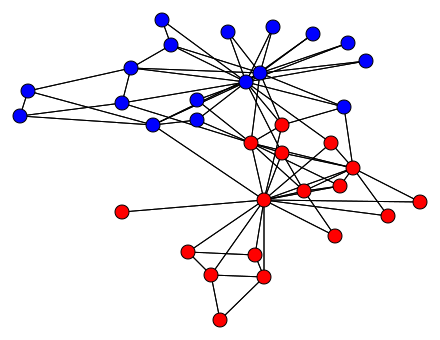

In [7]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with some eigenvectors.
* Display the embedding of the graph in dimension 2.
* Compare the clusters obtained with the sign of the first dimension to the ground-truth clusters.

In [50]:
spectral = Spectral(20, normalized=False)

In [51]:
spectral.fit(adjacency)

Spectral(n_components=20, decomposition='rw', regularization=-1, normalized=False)

In [10]:
# eigenvalues (adding the first)
eigenvalues = [1] + list(spectral.eigenvalues_)

In [52]:
# eigenvectors
eigenvectors = spectral.eigenvectors_

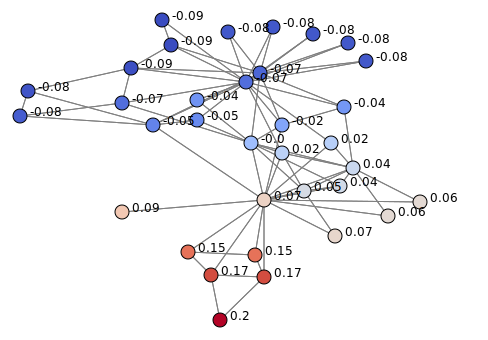

In [16]:
# display eigenvector
image = svg_graph(adjacency, position, scores=eigenvectors[:, 0], names = np.round(eigenvectors[:, 0],2))
SVG(image)

In [54]:
adjacency.shape

(34, 34)

In [53]:
embed = eigenvectors[:, :3]

In [55]:
from sklearn.metrics.pairwise import cosine_similarity

In [59]:
cosine_similarity(embed[0].reshape(1, -1), embed[1].reshape(1,-1))[0][0]

0.6875833500963777

In [60]:
count = 0
for i in range(33):
    for j in range(i, 34):
        dist = cosine_similarity(embed[i].reshape(1, -1), embed[j].reshape(1,-1))[0][0]
        if(dist<0):
            count = count + 1

In [61]:
count

371

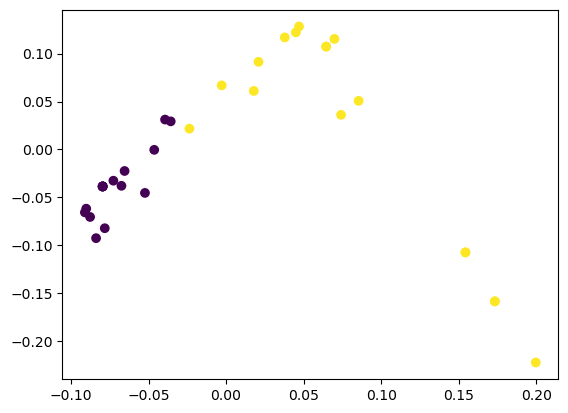

In [43]:
plt.scatter(eigenvectors[:, 0], eigenvectors[:, 1], c=labels_true)

In [18]:
np.average(labels_true==(eigenvectors[:,0]>=0))

0.9411764705882353

## Openflights


We now consider a larger graph. We use spectral embedding in dimension 20 to cluster the graph by k-means in the embedding space.

In [20]:
dataset = openflights

In [21]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

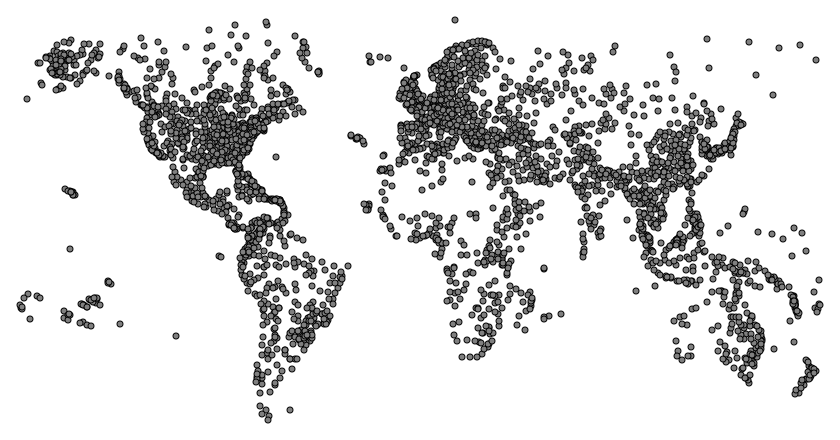

In [22]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with 8 clusters found by k-means in the embedding space.
* Do the same without normalization on the unit sphere (``normalized=False``).<br> Interpret the results. You might compute the distance of the barycenter of each cluster to the origin.

In [23]:
spectral = Spectral(20, normalized=True)

In [24]:
embedding = spectral.fit_transform(adjacency)

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans()
kmeans_labels = kmeans.fit_predict(embedding)

C:\Users\thang\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


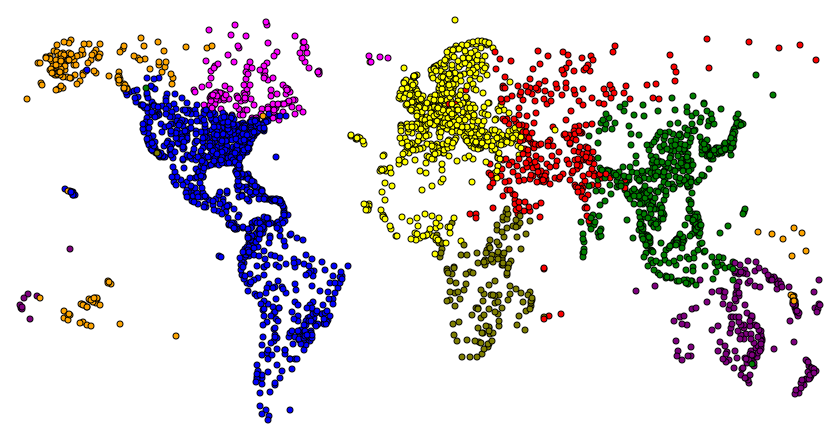

In [28]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, labels=kmeans_labels)
SVG(image)

In [26]:
svg_graph?

## 2. Directed graphs and bipartite graphs

We now work on directed graph and bipartite graphs. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we consider the embedding on the unit sphere (``normalized=True``).

## Wikipedia Vitals

In [63]:
dataset = wikivitals

In [64]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
words = dataset.names_col
labels = dataset.labels
names_labels = dataset.names_labels
labels_hierarchy = dataset.labels_hierarchy
names_labels_hierarchy = dataset.names_labels_hierarchy

## To do

We first consider the spectral embedding of the graph of links in dimension 20.

* List the 10 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space.
* Display the 3D-plot of each label in the embedding space (top 3 dimensions). <br>You might represent each label by a point located at the barycenter of the corresponding articles, with a size proportional to the number of articles. Use ``plotly`` for an interactive plot.
* Display the dendrogram of the top-100 articles on **Arts** (in terms of Personalized PageRank) given by the [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method) in the embedding space (hierarchical clustering).

In [65]:
degree = np.sum(adjacency, axis=1)
degree

matrix([[85],
        [76],
        [75],
        ...,
        [80],
        [42],
        [16]])

In [66]:
P = adjacency/degree

C:\Users\thang\miniconda3\lib\site-packages\scipy\sparse\_base.py:665: RuntimeWarning:

invalid value encountered in divide



In [71]:
P

matrix([[0.        , 0.01176471, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01315789, 0.        , 0.        , ..., 0.        , 0.        ,
         0.01315789],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.0625    , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [80]:
P = np.nan_to_num(P)

In [81]:
spectral = Spectral(20, normalized=True)
embedding = spectral.fit_transform(sparse.csr_matrix(P))

In [83]:
dataset

{'adjacency': <10011x10011 sparse matrix of type '<class 'numpy.bool_'>'
 	with 824999 stored elements in Compressed Sparse Row format>,
 'biadjacency': <10011x37845 sparse matrix of type '<class 'numpy.int64'>'
 	with 1363301 stored elements in Compressed Sparse Row format>,
 'labels': array([5, 5, 2, ..., 3, 6, 5], dtype=int64),
 'labels_hierarchy': array([ 930,  930,  534, ...,  637, 1170,  930], dtype=int64),
 'meta': {'name': 'Wikivitals (en)',
  'description': 'Vital articles of Wikipedia in English (level 4) with links between them and words used in summaries (tokenization by Spacy, model "en_core_web_lg").',
  'source': 'https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4',
  'date': 'June 2021'},
 'names': array(['0', '1', '100 metres', ..., 'Łódź', 'Śāriputra', '−1'],
       dtype='<U62'),
 'names_col': array(['Alexis', 'Cairo', 'subordinate', ..., 'parody', 'martyrdom',
        'Wyler'], dtype='<U26'),
 'names_labels': array(['Arts', 'Biological and health science

In [86]:
adjacency.shape

(10011, 10011)

In [85]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [93]:
avg_dist = np.zeros(10011)

In [91]:
np.average(cosine_similarity(embedding[0].reshape(1,-1), embedding))

-0.0429973375008989

In [95]:
for i in range(10011):
    avg_dist[i] = np.average(cosine_similarity(embedding[i].reshape(1,-1), embedding))
            

In [97]:
for i in range(11):
    print(i, names_labels[i], np.average(avg_dist[labels==i]))

0 Arts 0.0012825278712656183
1 Biological and health sciences -0.0117629580530917
2 Everyday life 0.015236626319655779
3 Geography 0.04657783421563499
4 History 0.035461717019356125
5 Mathematics -0.030334624314208
6 People 0.01316339486234952
7 Philosophy and religion -0.0037213540447161974
8 Physical sciences -0.010153920743848037
9 Society and social sciences 0.023464161333918203
10 Technology 0.01576964726199539


In [14]:
np.argwhere(np.char.find(names, 'Vincent van Gogh')>=0)

array([[9540]], dtype=int64)

In [15]:
van_gogh = 9540

In [16]:
spectral = Spectral(20, normalized=True)
embedding = spectral.fit_transform(adjacency)

In [27]:
embedding[van_gogh].shape

(20,)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
from sknetwork.ranking import top_k

cosine_dist = cosine_similarity(embedding[van_gogh].reshape(-1,20), embedding)[0]
top_10 = top_k(cosine_dist, k=11)
for i, node in enumerate(top_10):
    print(i, names[node])

0 Franz Marc
1 Henri de Toulouse-Lautrec
2 Paul Cézanne
3 Paul Gauguin
4 Vincent van Gogh
5 Musée National d'Art Moderne
6 Henri Rousseau
7 Georges Seurat
8 Post-Impressionism
9 Edvard Munch
10 Performance art


In [32]:
embedding[:,:3]

array([[ 0.42503893,  0.51386913,  0.27963475],
       [ 0.33185729,  0.48498392,  0.24996704],
       [-0.13670819, -0.02576116, -0.04964903],
       ...,
       [-0.31534988,  0.00515357, -0.09599424],
       [-0.11001586,  0.04279499,  0.15987447],
       [ 0.29961492,  0.48133212,  0.26160254]])

In [ ]:
embedding.shape

In [43]:
import plotly.express as px

In [42]:
count, unique = np.unique(labels, return_counts=True)
count, unique

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 673, 1479,  479, 1201,  680,  300, 1991,  435, 1097,  930,  746],
       dtype=int64))

In [47]:
labels_average

array([[ 0.00792176,  0.00792176,  0.00792176],
       [ 0.0019013 ,  0.0019013 ,  0.0019013 ],
       [-0.00130577, -0.00130577, -0.00130577],
       [-0.02819105, -0.02819105, -0.02819105],
       [-0.03998459, -0.03998459, -0.03998459],
       [ 0.06411442,  0.06411442,  0.06411442],
       [-0.02862968, -0.02862968, -0.02862968],
       [ 0.03782494,  0.03782494,  0.03782494],
       [ 0.01198069,  0.01198069,  0.01198069],
       [-0.01382906, -0.01382906, -0.01382906],
       [ 0.01937068,  0.01937068,  0.01937068]])

In [46]:
labels_average = np.zeros((11, 3))
for i in range(11):
    labels_average[i] = np.average(embedding[labels==i])
fig = px.scatter_3d(x=labels_average[:, 0],y=labels_average[:,1], z= labels_average[:,2], color=np.arange(11), size=count)
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(x=embedding[:, 0],y=embedding[:,1], z= embedding[:,2], color=labels)
fig.show()

In [36]:
df.to_numpy()

array([[5.1, 3.5, 1.4, 0.2, 'setosa', 1],
       [4.9, 3.0, 1.4, 0.2, 'setosa', 1],
       [4.7, 3.2, 1.3, 0.2, 'setosa', 1],
       [4.6, 3.1, 1.5, 0.2, 'setosa', 1],
       [5.0, 3.6, 1.4, 0.2, 'setosa', 1],
       [5.4, 3.9, 1.7, 0.4, 'setosa', 1],
       [4.6, 3.4, 1.4, 0.3, 'setosa', 1],
       [5.0, 3.4, 1.5, 0.2, 'setosa', 1],
       [4.4, 2.9, 1.4, 0.2, 'setosa', 1],
       [4.9, 3.1, 1.5, 0.1, 'setosa', 1],
       [5.4, 3.7, 1.5, 0.2, 'setosa', 1],
       [4.8, 3.4, 1.6, 0.2, 'setosa', 1],
       [4.8, 3.0, 1.4, 0.1, 'setosa', 1],
       [4.3, 3.0, 1.1, 0.1, 'setosa', 1],
       [5.8, 4.0, 1.2, 0.2, 'setosa', 1],
       [5.7, 4.4, 1.5, 0.4, 'setosa', 1],
       [5.4, 3.9, 1.3, 0.4, 'setosa', 1],
       [5.1, 3.5, 1.4, 0.3, 'setosa', 1],
       [5.7, 3.8, 1.7, 0.3, 'setosa', 1],
       [5.1, 3.8, 1.5, 0.3, 'setosa', 1],
       [5.4, 3.4, 1.7, 0.2, 'setosa', 1],
       [5.1, 3.7, 1.5, 0.4, 'setosa', 1],
       [4.6, 3.6, 1.0, 0.2, 'setosa', 1],
       [5.1, 3.3, 1.7, 0.5, 'setos

In [ ]:
from scipy.cluster.hierarchy import linkage

## To do

* Repeat the same experiments on the bipartite graph between articles and words.
* List the 10 articles and the 10 words that are closest to the word **painting** in the embedding space.

## To do

* Prove that the average cosine similarity between nodes in some set $S$ is equal to the square distance of the barycenter of $S$ to the origin.

For the following questions, first consider the graph of links, then the bipartite graph between articles and words:

* Compute the average cosine similarity between articles of the **Mammals** category (see hierarchical labels).
* Compare with the expected cosine similarity between two articles sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is close to 1, rank the 11 categories (Arts, History,...) by topicality. 
* List the 10 most topical and the 10 less topical hierarchical categories having at least 10 articles (like **Mammals**). 